# Project Title
### Data Engineering Capstone Project

#### Project Summary
I will use the US Immigration dataset I94 to analyse information about German residents travelling to the USA.

The project follows the follow steps:
* Step 1: Scope the Project and Gather Data
* Step 2: Explore and Assess the Data
* Step 3: Define the Data Model
* Step 4: Run ETL to Model the Data
* Step 5: Complete Project Write Up

In [1]:
# Do all imports and installs here
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# I want to suppress warning messages
import warnings
warnings.filterwarnings('ignore')

### Step 1: Scope the Project and Gather Data

#### Scope 
I'm interested in analysing the behavior of German residents travelling to the USA. I want this project to answer the below questions:

* Which types of Visas do Germans use?
* what is their travelling patterns over the year?
* what are their preferred states to reside in during their visits to USA?

To answer these questions, I will use the below datasets:

1. US immigration I94 dataset for all months during 2016
2. An external JSON file with the countries ISO codes to be able to extract German residents only from the Immigration dataset.
3. The US demographic dataset to extract the US states full name, as the states included in immigration datasets are abbreviated.

I will be using Pandas and matplotlib libraries for my analysis


In [3]:
# Let's start by takeing a look at the sample file to understand the components of Immigration dataset
df = pd.read_csv('immigration_data_sample.csv', index_col=0)

In [4]:
df.head()

,cicid,i94yr,i94mon,i94cit,i94res,i94port,arrdate,i94mode,i94addr,depdate,...,entdepu,matflag,biryear,dtaddto,gender,insnum,airline,admnum,fltno,visatype
2027561,4084316.0,2016.0,4.0,209.0,209.0,HHW,20566.0,1.0,HI,20573.0,...,NaN,M,1955.0,07202016,F,NaN,JL,5.658267e+10,00782,WT
2171295,4422636.0,2016.0,4.0,582.0,582.0,MCA,20567.0,1.0,TX,20568.0,...,NaN,M,1990.0,10222016,M,NaN,*GA,9.436200e+10,XBLNG,B2
589494,1195600.0,2016.0,4.0,148.0,112.0,OGG,20551.0,1.0,FL,20571.0,...,NaN,M,1940.0,07052016,M,NaN,LH,5.578047e+10,00464,WT
2631158,5291768.0,2016.0,4.0,297.0,297.0,LOS,20572.0,1.0,CA,20581.0,...,NaN,M,1991.0,10272016,M,NaN,QR,9.478970e+10,00739,B2
3032257,985523.0,2016.0,4.0,111.0,111.0,CHM,20550.0,3.0,NY,20553.0,...,NaN,M,1997.0,07042016,F,NaN,NaN,4.232257e+10,LAND,WT


In [5]:
df.columns

Index(['cicid', 'i94yr', 'i94mon', 'i94cit', 'i94res', 'i94port', 'arrdate',
       'i94mode', 'i94addr', 'depdate', 'i94bir', 'i94visa', 'count',
       'dtadfile', 'visapost', 'occup', 'entdepa', 'entdepd', 'entdepu',
       'matflag', 'biryear', 'dtaddto', 'gender', 'insnum', 'airline',
       'admnum', 'fltno', 'visatype'],
      dtype='object')

In [6]:
len(df.columns)

28

Using Chatgpt, here are the description of the columns,

* CICID: A unique identifier assigned to each individual record in the dataset.
* i94yr: The 4-digit year of the visitor's arrival in the United States.
* i94mon: The numeric month of the visitor's arrival in the United States.
* i94cit: The visitor's country of citizenship.
* i94res: The visitor's country of residence.
* i94port: The port of entry where the visitor arrived in the United States.
* arrdate: The arrival date of the visitor in the United States.
* i94mode: The mode of transportation used by the visitor to enter the United States.
* i94addr: The state where the visitor intends to reside in the United States.
* depdate: The departure date of the visitor from the United States.
* i94bir: The visitor's age at the time of arrival in the United States.
* i94visa: The type of visa the visitor used to enter theUnited States, such as business, pleasure, or student.
* count: The number of people included in the record.
* dtadfile: The date on which the data was added to the I94 file.
* visapost: The US embassy or consulate where the visitor obtained their visa.
* occup: The visitor's occupation.
* entdepa: The arrival flag - indicates the reason for the visitor's arrival in the US.
* entdepd: The departure flag - indicates the reason for the visitor's departure from the US.
* entdepu: Update flag - indicates if the arrival record was updated, typically for a change of address or other similar reasons.
* matflag: Match flag - indicates if the arrival and departure records match.
* biryear: The visitor's birth year.
* dtaddto: The date until which the visitor is admitted to stay in the US.
* gender: The visitor's gender.
* insnum: "Immigration and Naturalization Service (INS) number," which was a unique identifier assigned by the US government to individuals who applied for immigration benefits or who were admitted to the US as non-immigrant visitors.
* airline: The airline used by the visitor to travel to the US.
* admnum: Admission number - a unique number assigned to each arrival record.
* fltno: The flight number used by the non-immigrant visitor to enter the United States.
* visatype: The type of visa that a non-immigrant visitor used to enter the United States.

### Step 2: Explore and Assess the Data

I can see that column i94res includes a numerical value which represents the visitor's country of residence. I'm interested in retrieving the names of these countries. So, I uploaded a Json file that contains the ISO numerical code and the corresponding country name. Now let's use it.

In [7]:
codes=pd.read_json('countries.json')
codes.head(1)

,id,alpha2,alpha3,name
0,4,af,afg,Afghanistan


I'm Interested in analysing the data of German residents, so I will get its ISO code from the Codes dataset and use it to filter the data in the immigration dataset.

In [8]:
grmn_cd=codes[codes['name']=='Germany']['id'].iloc[0]
grmn_cd

276

Now let's get the immigration data for each month, and filter only the german residents records. I'm interested in exploring the types of visas column (visatype) and the state in which visitors will reside (i94addr), I will also keep the month column to be used in the analysis. 

I will ignore the count of persons within the same record that exists in column "count", and assume each record represents 1 person.

For each separate month, I will do 3 steps:

1. Filter and keep German residents
2. Delete the duplicates of the unique identifier 'cicid'
3. Delete the null values, and if their size is large (more than an assumed threshold), a warning message will display.

N.B: I preferred to work on this project in my local machine due to Udacity's timeout process, and I didn't find the immigration datasets uploaded directly in Udacity workspace, so I followed the below steps:

1. Used Udacity workspace to retrieve the monthly data
2. Wrote each month to a csv file
3. Downloaded all files from Udacity workspace
4. Uploaded all files to my local machine's Jupyter tree, and used them.

In [9]:
# set null values % threshold
thrshold= 0.3

def monthly_data(month):
    """Takes in a month dataset and returns a processed dataset with german residents"""
    
    data=pd.read_csv('Months/{}.csv'.format(month), low_memory=True, on_bad_lines='skip', usecols = ['cicid','i94mon','i94res','i94addr','visatype'])
    grmn=data[data['i94res']==grmn_cd].drop_duplicates(subset='cicid')
    rto=(len(grmn)-grmn.count().min())/len(grmn)
    [print("****{} WARNING: Number of Missing Values Exceeds Threshold****".format(month.upper())) if rto>thrshold else None][0]
    grmn.dropna(inplace=True)
    return grmn

In [10]:
# prepare a list with all months
months=['jan', 'feb','mar','apr','may','jun','jul','aug','sep','oct','nov','dec']

As a quality check, I will run the monthly_data function on all months and display the first row only just to make sure files were read normally and no month has a high number of missing data

In [11]:
for month in months:
    print('-----------------{}-----------------'.format(month.upper()))
    print(monthly_data(month).head(1))
    print()

-----------------JAN-----------------
       cicid  i94mon  i94res i94addr visatype
3136  5028.0     1.0   276.0      NY       F1

-----------------FEB-----------------
       cicid i94mon i94res i94addr visatype
1800  2656.0    2.0  276.0      NV       WT

-----------------MAR-----------------
       cicid  i94mon  i94res i94addr visatype
4689  5997.0     3.0   276.0      CA       WB

-----------------APR-----------------
  cicid i94mon i94res i94addr visatype
1   7.0    4.0  276.0      AL       F1

-----------------MAY-----------------
        cicid  i94mon  i94res i94addr visatype
8244  10067.0     5.0   276.0      NJ       WT

-----------------JUN-----------------
    cicid  i94mon  i94res i94addr visatype
10   41.0     6.0   276.0      CA       F1

-----------------JUL-----------------
  cicid i94mon i94res i94addr visatype
0   1.0    7.0  276.0      CA       WT

-----------------AUG-----------------
    cicid  i94mon  i94res i94addr visatype
13   88.0     8.0   276.0      FL     

Next, We will concatenate all months into one dataset, and drop the "i94res" column since it only include German residents' code

In [12]:
german=pd.concat([monthly_data(month) for month in months], ignore_index=True)
german.drop(labels='i94res', inplace=True, axis=1)

In [13]:
german.head(2)

,cicid,i94mon,i94addr,visatype
0,5028.0,1.0,NY,F1
1,8576.0,1.0,CA,WT


In [14]:
# Let's ensure that the # rows are more than 1 million (project requirement)
len(german)

1792456

In [15]:
# Now let's read the U.S. City Demographic Data

df_demo=pd.read_csv('us-cities-demographics.csv',delimiter=';')
df_demo.head(1)

,City,State,Median Age,Male Population,Female Population,Total Population,Number of Veterans,Foreign-born,Average Household Size,State Code,Race,Count
0,Silver Spring,Maryland,33.8,40601.0,41862.0,82463,1562.0,30908.0,2.6,MD,Hispanic or Latino,25924


In [16]:
# I'm only interested in the columns "State Code" & "State". I want to use them to form a dict

st=df_demo[['State Code','State']].set_index('State Code','State').to_dict()
st_dict=st['State']
print(len(st_dict))
st_dict

49


{'MD': 'Maryland',
 'MA': 'Massachusetts',
 'AL': 'Alabama',
 'CA': 'California',
 'NJ': 'New Jersey',
 'IL': 'Illinois',
 'AZ': 'Arizona',
 'MO': 'Missouri',
 'NC': 'North Carolina',
 'PA': 'Pennsylvania',
 'KS': 'Kansas',
 'FL': 'Florida',
 'TX': 'Texas',
 'VA': 'Virginia',
 'NV': 'Nevada',
 'CO': 'Colorado',
 'MI': 'Michigan',
 'CT': 'Connecticut',
 'MN': 'Minnesota',
 'UT': 'Utah',
 'AR': 'Arkansas',
 'TN': 'Tennessee',
 'OK': 'Oklahoma',
 'WA': 'Washington',
 'NY': 'New York',
 'GA': 'Georgia',
 'NE': 'Nebraska',
 'KY': 'Kentucky',
 'SC': 'South Carolina',
 'LA': 'Louisiana',
 'NM': 'New Mexico',
 'IA': 'Iowa',
 'RI': 'Rhode Island',
 'PR': 'Puerto Rico',
 'DC': 'District of Columbia',
 'WI': 'Wisconsin',
 'OR': 'Oregon',
 'NH': 'New Hampshire',
 'ND': 'North Dakota',
 'DE': 'Delaware',
 'OH': 'Ohio',
 'ID': 'Idaho',
 'IN': 'Indiana',
 'AK': 'Alaska',
 'MS': 'Mississippi',
 'HI': 'Hawaii',
 'SD': 'South Dakota',
 'ME': 'Maine',
 'MT': 'Montana'}

Now we have the data of 49 US state names and their codes. let's check the codes that exist in the immigration dataset

In [17]:
imm_cd=german['i94addr'].value_counts()

imc=imm_cd.to_dict()
imc

{'GU': 399335,
 'CA': 355209,
 'HI': 264895,
 'NY': 162599,
 'WA': 58978,
 'NJ': 58811,
 'FL': 56749,
 'NV': 55945,
 'TX': 53298,
 'MP': 43028,
 'IL': 36954,
 'MA': 25167,
 'GA': 24713,
 'MI': 18315,
 'VA': 17409,
 'PA': 15228,
 'MD': 13024,
 'DC': 11315,
 'AZ': 10284,
 'OR': 8399,
 'CO': 7606,
 'OH': 7087,
 'AL': 7052,
 'NC': 6915,
 'IN': 6490,
 'MN': 6107,
 'UT': 5795,
 'CT': 5082,
 'LA': 4887,
 'TN': 4309,
 'WI': 4285,
 'MO': 3957,
 'AK': 2350,
 'OK': 2175,
 'KY': 2129,
 'IA': 2108,
 'SC': 2101,
 'NE': 1906,
 'RI': 1613,
 'NH': 1567,
 'ME': 1503,
 'KS': 1493,
 'PR': 1373,
 'ID': 1320,
 'NM': 1282,
 'AR': 1029,
 'MT': 919,
 'GQ': 833,
 '99': 818,
 'DE': 817,
 'VT': 695,
 'MS': 683,
 'ND': 589,
 'US': 564,
 'SD': 423,
 'WV': 340,
 'XX': 320,
 'WY': 277,
 'VI': 242,
 'TT': 211,
 'UN': 207,
 'HA': 135,
 'NP': 134,
 'DF': 128,
 'TR': 118,
 'TE': 95,
 'AA': 78,
 'NB': 68,
 'KO': 49,
 'LO': 23,
 'CU': 19,
 'TO': 18,
 'IT': 17,
 'SE': 17,
 'IC': 17,
 'CQ': 16,
 'JF': 15,
 'QC': 12,
 'NU': 1

In [18]:
len(imc)

214

There seems to be alot of codes that exist in the immigration dataset while not in the demographic dataset. Let's see the codes of the missing states

In [19]:
no=[(k, imc[k])for k in imc.keys()if k not in st_dict.keys()]
no

[('GU', 399335),
 ('MP', 43028),
 ('GQ', 833),
 ('99', 818),
 ('VT', 695),
 ('US', 564),
 ('WV', 340),
 ('XX', 320),
 ('WY', 277),
 ('VI', 242),
 ('TT', 211),
 ('UN', 207),
 ('HA', 135),
 ('NP', 134),
 ('DF', 128),
 ('TR', 118),
 ('TE', 95),
 ('AA', 78),
 ('NB', 68),
 ('KO', 49),
 ('LO', 23),
 ('CU', 19),
 ('TO', 18),
 ('IT', 17),
 ('SE', 17),
 ('IC', 17),
 ('CQ', 16),
 ('JF', 15),
 ('QC', 12),
 ('NU', 11),
 ('II', 11),
 ('AN', 11),
 ('HO', 11),
 ('ON', 10),
 ('NW', 10),
 ('GE', 10),
 ('AB', 10),
 ('JQ', 9),
 ('BO', 8),
 ('BC', 8),
 ('AE', 7),
 ('SF', 7),
 ('DA', 7),
 ('MC', 7),
 ('VQ', 6),
 ('LI', 6),
 ('SL', 6),
 ('SA', 6),
 ('JE', 6),
 ('.C', 6),
 ('YQ', 6),
 ('MX', 6),
 ('UK', 6),
 ('PN', 5),
 ('AP', 5),
 ('BQ', 5),
 ('SO', 5),
 ('GY', 4),
 ('CN', 4),
 ('BU', 4),
 ('PE', 4),
 ('WQ', 4),
 ('CL', 3),
 ('NO', 3),
 ('C', 3),
 ('CH', 3),
 ('SU', 3),
 ('60', 3),
 ('OA', 3),
 ('LP', 3),
 ('NR', 3),
 ('AT', 3),
 ('H', 3),
 ('TA', 3),
 ('**', 3),
 ('PH', 3),
 ('FI', 2),
 ('EL', 2),
 ('PU', 

The number of records with unknown state name seems to be high, specially for the first 2 states ('GU' & 'MP'). We will not be able to drop them since they represent around 25% of the data. Since we are building a pipeline, then it's important to avoid hard coding steps by avoiding manual search for these two values. The solution will be to use a new dataset that contains the state name and the corresponding state code

In [20]:
full_code=pd.read_csv('georef-united-states-of-america-zc-point@public.csv',delimiter=';')
full_code.head(1)

,Zip Code,Official USPS city name,Official USPS State Code,Official State Name,ZCTA,ZCTA parent,Population,Density,Primary Official County Code,Primary Official County Name,County Weights,Official County Name,Official County Code,Imprecise,Military,Timezone,Geo Point
0,90005,Los Angeles,CA,California,True,NaN,39732.0,14151.8,6037,Los Angeles,"{""06037"": ""100""}",Los Angeles,6037,False,False,America/Los_Angeles,"34.05912, -118.30654"


In [21]:
# Let's get the required dictionary from our new dataset

stat=full_code[['Official USPS State Code','Official State Name']].set_index('Official USPS State Code','Official State Name').to_dict()
stat_dict=stat['Official State Name']
len(stat_dict)

56

In [22]:
# Once again, let's see if there is a missing state code
non=[(k, imc[k])for k in imc.keys()if k not in stat_dict.keys()]
non

[('GQ', 833),
 ('99', 818),
 ('US', 564),
 ('XX', 320),
 ('TT', 211),
 ('UN', 207),
 ('HA', 135),
 ('NP', 134),
 ('DF', 128),
 ('TR', 118),
 ('TE', 95),
 ('AA', 78),
 ('NB', 68),
 ('KO', 49),
 ('LO', 23),
 ('CU', 19),
 ('TO', 18),
 ('IT', 17),
 ('SE', 17),
 ('IC', 17),
 ('CQ', 16),
 ('JF', 15),
 ('QC', 12),
 ('NU', 11),
 ('II', 11),
 ('AN', 11),
 ('HO', 11),
 ('ON', 10),
 ('NW', 10),
 ('GE', 10),
 ('AB', 10),
 ('JQ', 9),
 ('BO', 8),
 ('BC', 8),
 ('AE', 7),
 ('SF', 7),
 ('DA', 7),
 ('MC', 7),
 ('VQ', 6),
 ('LI', 6),
 ('SL', 6),
 ('SA', 6),
 ('JE', 6),
 ('.C', 6),
 ('YQ', 6),
 ('MX', 6),
 ('UK', 6),
 ('PN', 5),
 ('AP', 5),
 ('BQ', 5),
 ('SO', 5),
 ('GY', 4),
 ('CN', 4),
 ('BU', 4),
 ('PE', 4),
 ('WQ', 4),
 ('CL', 3),
 ('NO', 3),
 ('C', 3),
 ('CH', 3),
 ('SU', 3),
 ('60', 3),
 ('OA', 3),
 ('LP', 3),
 ('NR', 3),
 ('AT', 3),
 ('H', 3),
 ('TA', 3),
 ('**', 3),
 ('PH', 3),
 ('FI', 2),
 ('EL', 2),
 ('PU', 2),
 ('AU', 2),
 ('TU', 2),
 ('BA', 2),
 ('LN', 2),
 ('IO', 2),
 ('94', 2),
 ('MR', 2),
 

This time, the number of states with unknown code is smaller. I will replace these states' names with 'Others'

In [23]:
stat_dict.update({key: 'Others' for key in imc.keys() if key not in stat_dict})

In [24]:
print(len(stat_dict))
stat_dict

215


{'CA': 'California',
 'HI': 'Hawaii',
 'GU': 'Guam',
 'OR': 'Oregon',
 'WA': 'Washington',
 'SD': 'South Dakota',
 'PR': 'Puerto Rico',
 'MA': 'Massachusetts',
 'RI': 'Rhode Island',
 'NH': 'New Hampshire',
 'ME': 'Maine',
 'VT': 'Vermont',
 'CT': 'Connecticut',
 'NJ': 'New Jersey',
 'NY': 'New York',
 'PA': 'Pennsylvania',
 'DE': 'Delaware',
 'DC': 'District of Columbia',
 'VA': 'Virginia',
 'MD': 'Maryland',
 'WV': 'West Virginia',
 'NC': 'North Carolina',
 'SC': 'South Carolina',
 'GA': 'Georgia',
 'FL': 'Florida',
 'AL': 'Alabama',
 'TN': 'Tennessee',
 'MS': 'Mississippi',
 'KY': 'Kentucky',
 'OH': 'Ohio',
 'IN': 'Indiana',
 'MI': 'Michigan',
 'IA': 'Iowa',
 'WI': 'Wisconsin',
 'MN': 'Minnesota',
 'ND': 'North Dakota',
 'MT': 'Montana',
 'IL': 'Illinois',
 'MO': 'Missouri',
 'KS': 'Kansas',
 'NE': 'Nebraska',
 'LA': 'Louisiana',
 'AR': 'Arkansas',
 'OK': 'Oklahoma',
 'TX': 'Texas',
 'CO': 'Colorado',
 'WY': 'Wyoming',
 'ID': 'Idaho',
 'UT': 'Utah',
 'AZ': 'Arizona',
 'NM': 'New Mex

In [25]:
# retrieve the full state name and add it to the german dataset
german['State']= german['i94addr'].apply(lambda x: stat_dict[x])
german.head(2)

,cicid,i94mon,i94addr,visatype,State
0,5028.0,1.0,NY,F1,New York
1,8576.0,1.0,CA,WT,California


In [26]:
# I want to display a warning if the number of 'Others' state exceeded a certain threshold, 
# this will be helpful if the file was updated to ensure that the # of others will not be large in the new records.

st_thrsh=0.15
others_ratio=german[german['State']=='Others']['State'].count()/len(german)

[print("***** WARNING: Number of unknown (Others) states Exceeds Threshold****") if others_ratio>st_thrsh else None][0]

By Now, our dataset has reached its final form and is now ready for our analysis

Now let's answer our questions:
Which types of Visas do Germans use?

In [27]:
visas=german['visatype'].value_counts()
visas

WT         964463
GMT        481685
WB         126994
F1          91020
B2          82260
B1          23872
E2           9311
F2           7505
E1           1288
CP           1178
M1           1097
GMB          1059
I             576
M2            109
I1             35
567183          1
O               1
F               1
20655.0         1
Name: visatype, dtype: int64

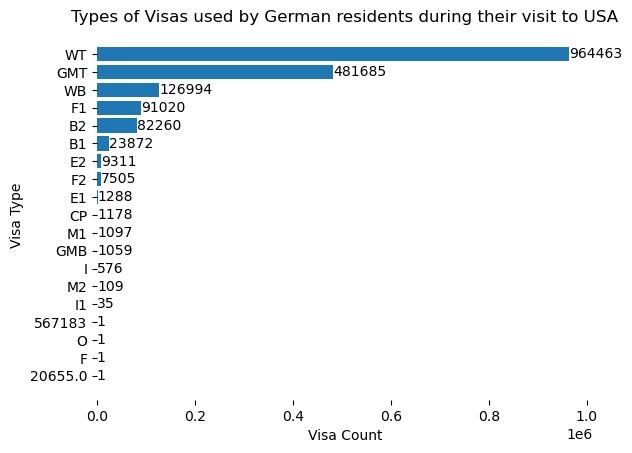

In [28]:
fig, ax = plt.subplots()
plt.title('Types of Visas used by German residents during their visit to USA')
plt.xlabel('Visa Count')
plt.ylabel('Visa Type')
bars = ax.barh(visas.index, visas)
ax.bar_label(bars)
plt.box(False)
plt.gca().invert_yaxis();

It seems that "WT" & "GMT" are the most populat visa types. Now let's check their travelling pattern over the year.

In [29]:
pattern=german['i94mon'].value_counts()
pattern

7.0     181810
12.0    169091
9.0     166518
1.0     160366
8.0     158425
10.0    155070
6.0     153713
11.0    142254
5.0     139895
2.0     130969
4.0     121217
3.0     109486
2.0       2175
7.0       1466
4.0          1
Name: i94mon, dtype: int64

I find it strange that some indexes are repeated (like 4). Let's check their data types

In [30]:
[type(ind) for ind in pattern.index]

[float,
 float,
 float,
 float,
 float,
 float,
 float,
 float,
 float,
 float,
 float,
 float,
 str,
 str,
 str]

It seems that some months' numbers are in string format. we need to convert all index values to float.

In [31]:
german['i94mon']=german['i94mon'].apply(lambda x: float(x))

Now back to our value counts, we will extraxt the count of records per month

In [32]:
pat=german['i94mon'].value_counts()
pat.sort_index(inplace=True)
pat

1.0     160366
2.0     133144
3.0     109486
4.0     121218
5.0     139895
6.0     153713
7.0     183276
8.0     158425
9.0     166518
10.0    155070
11.0    142254
12.0    169091
Name: i94mon, dtype: int64

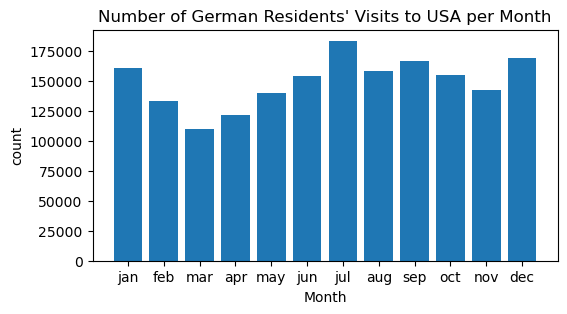

In [33]:
plt.figure(figsize=(6,3))
plt.bar(x=pat.index, height=pat)
plt.title("Number of German Residents' Visits to USA per Month")
plt.xlabel('Month')
plt.ylabel('count');
plt.xticks(ticks= pat.index,labels=months);

The count over month is a bit similar with no spikes (except for March & April)

what are their preferred states to reside in during their visits to USA? I will display the top 10

In [34]:
pref=german['State'].value_counts()
pref[:10].index

Index(['Guam', 'California', 'Hawaii', 'New York', 'Washington', 'New Jersey',
       'Florida', 'Nevada', 'Texas', 'Northern Mariana Islands'],
      dtype='object')

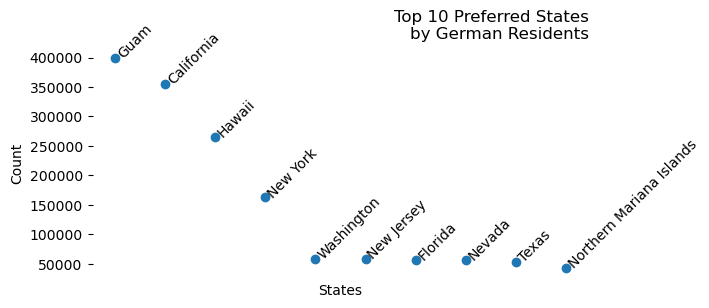

In [35]:
cnt = list(pref[:10])
lbl = np.arange(10)
stt = list(pref[:10].index)

fig, ax = plt.subplots()
fig.set_figheight(3)
ax.scatter(lbl, cnt)
for i, txt in enumerate(stt):
    ax.annotate(txt, (lbl[i], cnt[i]), rotation=45)
plt.title('Top 10 Preferred States' +  "\n" + 'by German Residents', loc='right')
plt.xlabel('States')
plt.xticks([])
plt.ylabel('Count')

plt.box(False);

It seems that Guam & California are the go-to states for German residents.

Now we have answers for our questions!

### Step 3: Define the Data Model
#### 3.1 Conceptual Data Model
The data model used in this project is Star Schema. The reason for choosing it is that the datasets used are one fact table (Immigration dataset), and 2 dimensions tables (country ISO codes & states abbrev. table) which were used to complete the data in the main Immigration dataset and make it reach to a form that will be ready for analysis.

#### 3.2 Mapping Out Data Pipelines
List the steps necessary to pipeline the data into the chosen data model

1. Retrieve the immigration data from its source
2. Create a function (monthly_data) that takes in raw data files, does the required pre-processing, and displays the needed warnings-if any-.
3. Use dimention table (ISO code) to filter the required data (German residents) 
4. Join the fact table with dimentions table to retrieve the required data (State full name), and display a warning if the number of unknown states increase, so that in future runs after the files update, we could ensure that we don't have a huge number of missing state name. We also used "Others" to fill missing/incorrect state name.

### Step 4: Run Pipelines to Model the Data 
#### 4.1 Create the data model

Build the data pipelines to create the data model: Already done in the above steps

#### 4.2 Data Quality Checks
Explain the data quality checks you'll perform to ensure the pipeline ran as expected. These could include:
 * Integrity constraints on the relational database (e.g., unique key, data type, etc.)
 * Unit tests for the scripts to ensure they are doing the right thing
 * Source/Count checks to ensure completeness
 
Run Quality Checks:

Check #1: Checking the % of null values before dropping them, and displaying an error message if the % exceeded a given threshold.

Check #2: Checking the % of states with unknow names (refereed to as "others") and displaying a warning message if the % exceeded a given threshold.

Check #3: Dropping duplicated rows using the unique identifier column "cicid"

#### 4.3 Data dictionary 
Create a data dictionary for your data model. For each field, provide a brief description of what the data is and where it came from. You can include the data dictionary in the notebook or in a separate file (Included in a separate file).

#### Step 5: Complete Project Write Up
* Clearly state the rationale for the choice of tools and technologies for the project.

I used only Jupyter notebook for the project, since the data size was still small and all project stages could be successfully run through the notebook.

* Propose how often the data should be updated and why.

From the analytics point of view, this data should be run once per month, since the analysis was built on month granularity. So any change in data behavior should be detected on the month level not on weekly or daily...etc specially that the dataset doesn't include columns for weeks or days timestamp. The smallest time level included is the month column. 

* Write a description of how you would approach the problem differently under the following scenarios:
 * The data was increased by 100x.
 
 I would upload the datasets to AWS and use it for analysis, since the data size will increase and it won't be efficient to run it in the notebook

 * The data populates a dashboard that must be updated on a daily basis by 7am every day.
 
I would use airflow and create a DAG with a scheduled daily run

 * The database needed to be accessed by 100+ people.
 
 I would upload all datasets on the cloud and use its storage capacity, and create different roles with different access for each group to be able to access the data with their proposed limitation.